# 📊 High Valyrian NLP — Tokenization & Embedding Analysis

**Tugas Individu Week 3 — NLP, Pradita University**

Notebook ini menjalankan seluruh pipeline secara terpadu:
1. **Text Cleaning** — normalisasi dan pembersihan corpus
2. **Custom Tokenizer** — word-level tokenization
3. **Vocabulary & Token ID Mapping** — frequency-based vocab
4. **Word Embedding** — PPMI + SVD
5. **Quantitative Analysis** — statistik, visualisasi, dan evaluasi embedding

**Corpus**: [High Valyrian (Game of Thrones) — Kaggle](https://www.kaggle.com/datasets/viceriomarinowski/high-valyrian-corpus-from-game-of-thrones)

---
## 0. Setup & Imports

In [1]:
import json
import re
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('dark_background')

BASE = Path('.')
print('✅ Setup complete')

✅ Setup complete


---
## 1. Text Cleaning

Membaca corpus mentah dan menerapkan langkah-langkah pembersihan.

In [ ]:
# Run cleaning script
exec(open('clean_corpus.py', encoding='utf-8').read())

In [17]:
# Preview cleaned corpus
cleaned = Path('cleaned_corpus.txt').read_text(encoding='utf-8')
cleaned_lines = [l for l in cleaned.split('\n') if l.strip()]
all_words = cleaned.split()
unique_words = set(all_words)
print(f'Total baris:       {len(cleaned_lines)}')
print(f'Total kata:        {len(all_words)}')
print(f'Kata unik:         {len(unique_words)}')
print(f'Rasio unik/total:  {len(unique_words)/len(all_words)*100:.1f}%')
print()
print('--- 5 baris pertama ---')
for line in cleaned_lines[:5]:
    print(f'  {line[:100]}...' if len(line) > 100 else f'  {line}')

Total baris:       666
Total kata:        14218
Kata unik:         497
Rasio unik/total:  3.5%

--- 5 baris pertama ---
  ānogar ziry aōhaeot se hēdrȳ jaelagon issi. henujagon hen pryjari, issi se hēdrȳ henujagon se daenar...
  henujagon jaelagon, pryjari se qilōni se ossēnagon jorrāelagon henujagon tolvī. daenarī se dōre issi...
  onogār jaelagon, pryjari se henujagon se glēdrī issi se hēdrȳ henujagon se glȳrzi. daenarī se rijā i...
  henujagon se jaelagon, hēdrȳ pryjari se tepagon issi se hēdrȳ henujagon se zaldrīzi. daenarī se pār ...
  ānogar jaelagon, henujagon pryjari se dārī issi se hēdrȳ henujagon se vējose. daenarī se rūjagon iss...


---
## 2. Custom Tokenizer

Word-level tokenizer yang dibuat dari scratch tanpa library NLP:
- Punctuation dipisah sebagai token tersendiri
- Setiap baris dibungkus `<BOS>` (Begin of Sentence) dan `<EOS>` (End of Sentence)

In [4]:
def tokenize(text: str) -> list[str]:
    text = text.lower()
    text = re.sub(r'([.!?,;:])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.split()

def tokenize_line(line: str) -> list[str]:
    tokens = tokenize(line)
    return ['<BOS>'] + tokens + ['<EOS>'] if tokens else []

# Tokenize all lines
all_tokenized = [tokenize_line(l) for l in cleaned_lines]
all_tokenized = [t for t in all_tokenized if t]
all_tokens_flat = [tok for line in all_tokenized for tok in line]

print(f'Lines tokenized: {len(all_tokenized)}')
print(f'Total tokens:    {len(all_tokens_flat)}')
print()
print('--- Contoh tokenisasi ---')
for i in range(3):
    print(f'  Line {i+1}: {all_tokenized[i][:8]}...')

Lines tokenized: 666
Total tokens:    18125

--- Contoh tokenisasi ---
  Line 1: ['<BOS>', 'ānogar', 'ziry', 'aōhaeot', 'se', 'hēdrȳ', 'jaelagon', 'issi']...
  Line 2: ['<BOS>', 'henujagon', 'jaelagon', ',', 'pryjari', 'se', 'qilōni', 'se']...
  Line 3: ['<BOS>', 'onogār', 'jaelagon', ',', 'pryjari', 'se', 'henujagon', 'se']...


---
## 3. Vocabulary & Token ID Mapping

Membangun vocabulary yang diurutkan berdasarkan frekuensi (descending).
Special tokens: `<PAD>=0`, `<UNK>=1`, `<BOS>=2`, `<EOS>=3`

In [5]:
SPECIAL_TOKENS = ['<PAD>', '<UNK>', '<BOS>', '<EOS>']

freq = Counter(all_tokens_flat)
sorted_tokens = sorted(
    [t for t in freq if t not in SPECIAL_TOKENS],
    key=lambda t: (-freq[t], t)
)

vocab = {tok: i for i, tok in enumerate(SPECIAL_TOKENS)}
for i, tok in enumerate(sorted_tokens):
    vocab[tok] = len(SPECIAL_TOKENS) + i

def encode(tokens, vocab):
    unk_id = vocab['<UNK>']
    return [vocab.get(t, unk_id) for t in tokens]

def decode(ids, vocab):
    id2tok = {v: k for k, v in vocab.items()}
    return [id2tok.get(i, '<UNK>') for i in ids]

print(f'Vocab size: {len(vocab)}')
print(f'  Special:  {len(SPECIAL_TOKENS)}')
print(f'  Words:    {len(vocab) - len(SPECIAL_TOKENS)}')
print()
# Sanity check
sample = all_tokenized[0]
enc = encode(sample, vocab)
dec = decode(enc, vocab)
print(f'Encode → Decode match: {sample == dec} ✅' if sample == dec else '❌ MISMATCH')

Vocab size: 299
  Special:  4
  Words:    295

Encode → Decode match: True ✅


### 3.1 Distribusi Frekuensi Token

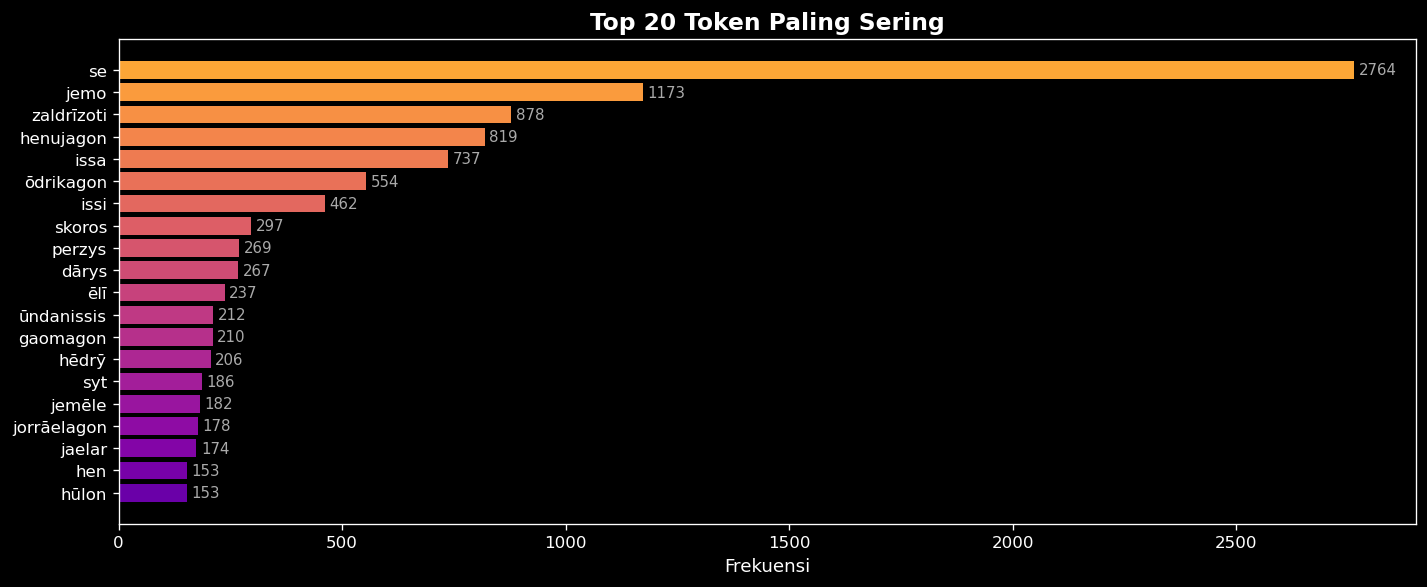

In [6]:
# Top 20 tokens (excluding special)
word_freq = {t: c for t, c in freq.items() if t not in SPECIAL_TOKENS and t not in '.,?!;:'}
top20 = sorted(word_freq.items(), key=lambda x: -x[1])[:20]

fig, ax = plt.subplots(figsize=(12, 5))
tokens_list = [t[0] for t in top20]
counts_list = [t[1] for t in top20]
bars = ax.barh(tokens_list[::-1], counts_list[::-1],
               color=plt.cm.plasma(np.linspace(0.2, 0.8, 20)))
ax.set_xlabel('Frekuensi', fontsize=11)
ax.set_title('Top 20 Token Paling Sering', fontsize=14, fontweight='bold')
for bar, count in zip(bars, counts_list[::-1]):
    ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
            str(count), va='center', fontsize=9, color='#aaa')
plt.tight_layout()
plt.savefig('top20_tokens.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Zipf's Law Check

Hukum Zipf: frekuensi token ke-r ≈ 1/r. Log-log plot seharusnya mendekati garis lurus.

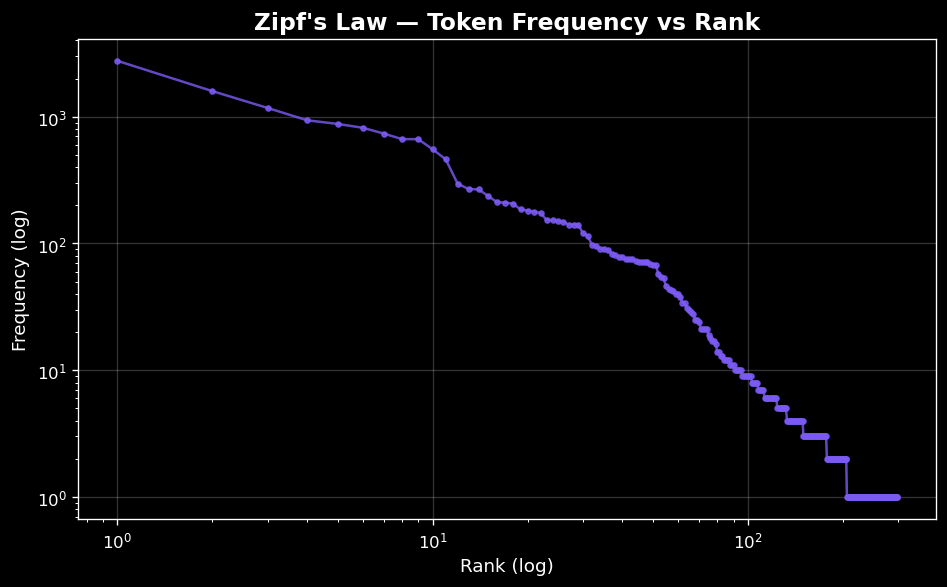

In [7]:
sorted_freq = sorted(freq.values(), reverse=True)
ranks = np.arange(1, len(sorted_freq) + 1)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(ranks, sorted_freq, 'o-', color='#7c5bf5', markersize=3, alpha=0.8)
ax.set_xlabel('Rank (log)', fontsize=11)
ax.set_ylabel('Frequency (log)', fontsize=11)
ax.set_title("Zipf's Law — Token Frequency vs Rank", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig('zipf_law.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Word Embedding (PPMI + SVD)

Membangun word embedding dari scratch:
1. **Co-occurrence matrix** — menghitung kemunculan bersama dalam context window
2. **PPMI** — Positive Pointwise Mutual Information, mengurangi bias kata frequent
3. **SVD** — Singular Value Decomposition, mereduksi dimensi

### Kenapa 50 dimensi?

| Aspek | Penjelasan |
|---|---|
| Rule of thumb | dim ≈ √vocab ≈ √299 ≈ 17, dinaikkan ke 50 untuk ekspresivitas |
| Overfitting | >100 dim dengan 299 vocab = terlalu banyak parameter vs data |
| SVD decay | Singular values turun cepat; komponen setelah ~50 hanya noise |
| Standar | GloVe/Word2Vec pakai 100-300 dim untuk vocab 100K+; kita proporsional |

In [8]:
EMBED_DIM = 50
WINDOW_SIZE = 4

# Corpus tokens (tanpa BOS/EOS untuk embedding)
corpus_tokens = []
for line in cleaned_lines:
    corpus_tokens.extend(tokenize(line))

print(f'Corpus tokens: {len(corpus_tokens)}')
print(f'Vocab size:    {len(vocab)}')

Corpus tokens: 16793
Vocab size:    299


### 4.1 Co-occurrence Matrix

In [9]:
V = len(vocab)
cooc = np.zeros((V, V), dtype=np.float64)

for i, token in enumerate(corpus_tokens):
    if token not in vocab:
        continue
    idx_i = vocab[token]
    start = max(0, i - WINDOW_SIZE)
    end = min(len(corpus_tokens), i + WINDOW_SIZE + 1)
    for j in range(start, end):
        if j == i:
            continue
        ctx = corpus_tokens[j]
        if ctx not in vocab:
            continue
        cooc[idx_i][vocab[ctx]] += 1.0 / abs(i - j)

non_zero = np.count_nonzero(cooc)
sparsity = 1.0 - non_zero / (V * V)
print(f'Matrix shape:   {cooc.shape}')
print(f'Non-zero cells: {non_zero}')
print(f'Sparsity:       {sparsity:.1%}')

Matrix shape:   (299, 299)
Non-zero cells: 6524
Sparsity:       92.7%


### 4.2 PPMI Weighting

In [10]:
total = cooc.sum()
row_sum = cooc.sum(axis=1, keepdims=True)
col_sum = cooc.sum(axis=0, keepdims=True)
row_sum[row_sum == 0] = 1
col_sum[col_sum == 0] = 1

with np.errstate(divide='ignore', invalid='ignore'):
    pmi = np.log2(cooc * total / (row_sum * col_sum))
pmi[~np.isfinite(pmi)] = 0
ppmi = np.maximum(pmi, 0)

print(f'PPMI max:  {ppmi.max():.4f}')
print(f'PPMI mean: {ppmi.mean():.4f}')

PPMI max:  11.9765
PPMI mean: 0.1694


### 4.3 SVD → 50 Dimensions

In [11]:
U, S, Vt = np.linalg.svd(ppmi, full_matrices=False)
k = min(EMBED_DIM, len(S))
embeddings = U[:, :k] * np.sqrt(S[:k])

print(f'Embedding shape: {embeddings.shape}')
print(f'File size:       {embeddings.nbytes / 1024:.1f} KB')

# Save
np.save('embedding.npy', embeddings)
print('\n✅ Saved embedding.npy')

Embedding shape: (299, 50)
File size:       116.8 KB

✅ Saved embedding.npy


### 4.4 Singular Value Decay

Menunjukkan bahwa komponen setelah ~50 sudah mendekati 0 (noise).

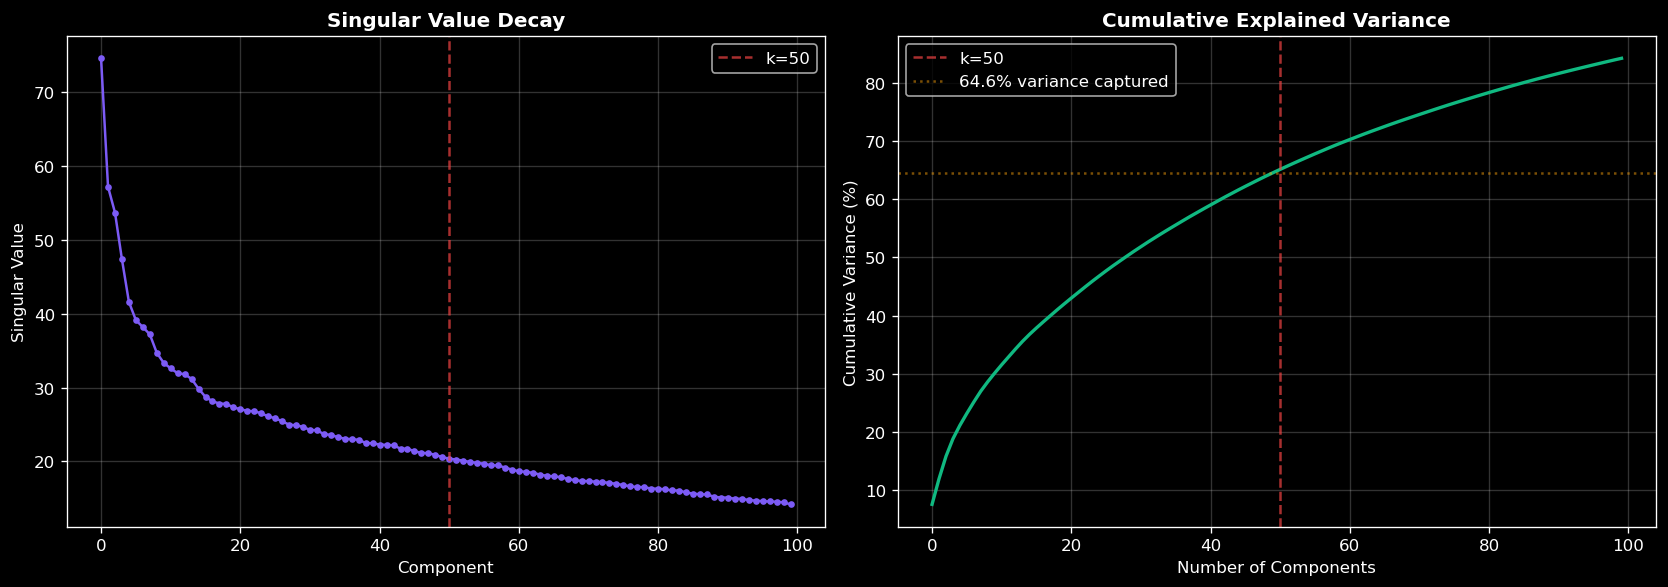


50 komponen menangkap 64.6% dari total variance


In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Singular values
ax1.plot(S[:100], 'o-', markersize=3, color='#7c5bf5')
ax1.axvline(x=EMBED_DIM, color='#ef4444', linestyle='--', alpha=0.7, label=f'k={EMBED_DIM}')
ax1.set_xlabel('Component')
ax1.set_ylabel('Singular Value')
ax1.set_title('Singular Value Decay', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.2)

# Cumulative explained variance
explained = np.cumsum(S**2) / np.sum(S**2) * 100
ax2.plot(explained[:100], '-', color='#10b981', linewidth=2)
ax2.axvline(x=EMBED_DIM, color='#ef4444', linestyle='--', alpha=0.7, label=f'k={EMBED_DIM}')
ax2.axhline(y=explained[EMBED_DIM-1], color='#f59e0b', linestyle=':', alpha=0.5,
            label=f'{explained[EMBED_DIM-1]:.1f}% variance captured')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance (%)')
ax2.set_title('Cumulative Explained Variance', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('svd_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'\n50 komponen menangkap {explained[49]:.1f}% dari total variance')

---
## 5. Analisis Kuantitatif Embedding

### 5.1 Cosine Similarity — Kata Paling Mirip

In [13]:
def cosine_sim(a, b):
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    return float(np.dot(a, b) / (na * nb)) if na and nb else 0.0

def top_similar(word, k=8):
    if word not in vocab: return []
    vec = embeddings[vocab[word]]
    sims = [(t, cosine_sim(vec, embeddings[i])) for t, i in vocab.items() if t != word]
    return sorted(sims, key=lambda x: -x[1])[:k]

probe_words = ['se', 'zaldrīzoti', 'dārys', 'jorrāelagon', 'perzys',
               'henujagon', 'dāervon', 'gaomagon', 'issa', 'skoros']

for word in probe_words:
    similar = top_similar(word, k=5)
    print(f"\n  '{word}' (ID {vocab[word]})")
    for t, s in similar:
        print(f'    → {t:<22} sim={s:+.4f}')


  'se' (ID 4)
    → jorrāelagon            sim=+0.6707
    → henujagon              sim=+0.5783
    → gūrēbzi                sim=+0.5375
    → hēdrȳ                  sim=+0.5357
    → ryndāro                sim=+0.5251

  'zaldrīzoti' (ID 8)
    → ōdrikagon              sim=+0.7807
    → dāervosas              sim=+0.7389
    → drējotas               sim=+0.6913
    → sytilus                sim=+0.6766
    → ūndanissis             sim=+0.6654

  'dārys' (ID 15)
    → emagon                 sim=+0.5961
    → jemo                   sim=+0.5220
    → hūlon                  sim=+0.5153
    → jaelar                 sim=+0.5063
    → perzys                 sim=+0.4694

  'jorrāelagon' (ID 22)
    → se                     sim=+0.6707
    → hēdrȳ                  sim=+0.6519
    → daenarī                sim=+0.6355
    → gūrēbzi                sim=+0.6041
    → glaesagon              sim=+0.5584

  'perzys' (ID 14)
    → onosor                 sim=+0.6238
    → nykēlo                 sim=+0.5

### 5.2 Similarity Heatmap

Heatmap cosine similarity antara top-30 kata (by frequency).

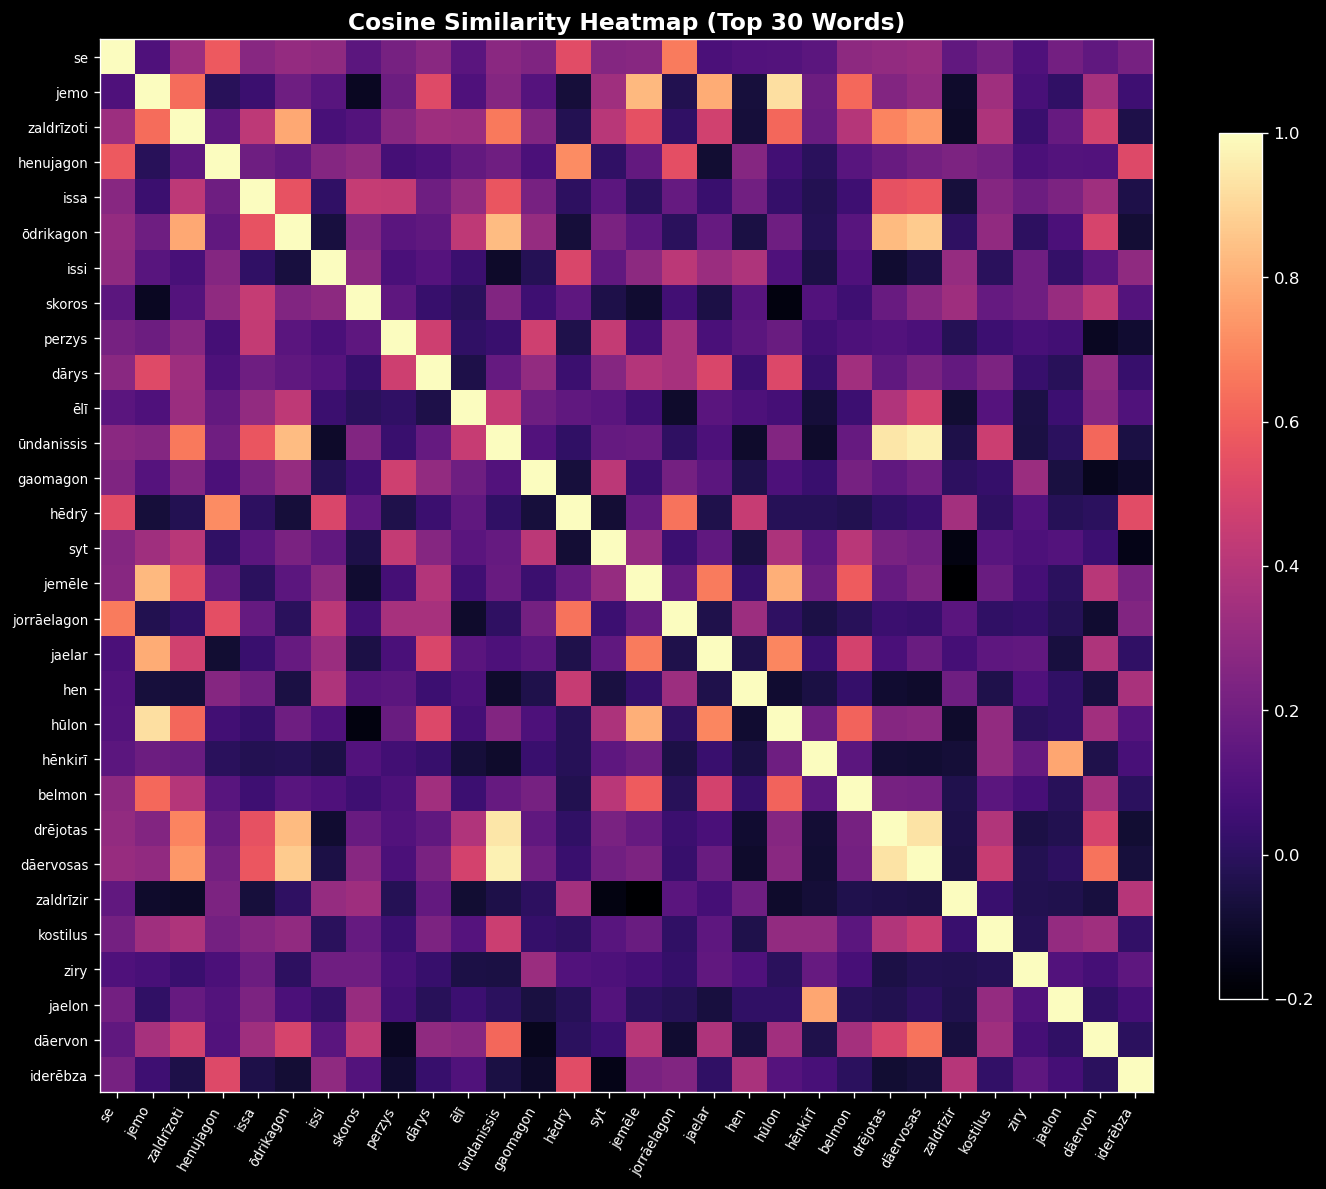

In [14]:
# Top 30 words
top30_words = [t[0] for t in sorted(word_freq.items(), key=lambda x: -x[1])[:30]]
top30_idx = [vocab[w] for w in top30_words]
top30_vecs = embeddings[top30_idx]

# Compute pairwise cosine similarity
norms = np.linalg.norm(top30_vecs, axis=1, keepdims=True)
norms[norms == 0] = 1
normed = top30_vecs / norms
sim_matrix = normed @ normed.T

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(sim_matrix, cmap='magma', vmin=-0.2, vmax=1.0)
ax.set_xticks(range(len(top30_words)))
ax.set_yticks(range(len(top30_words)))
ax.set_xticklabels(top30_words, rotation=60, ha='right', fontsize=8)
ax.set_yticklabels(top30_words, fontsize=8)
ax.set_title('Cosine Similarity Heatmap (Top 30 Words)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.savefig('similarity_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.3 Embedding Visualization (PCA 2D)

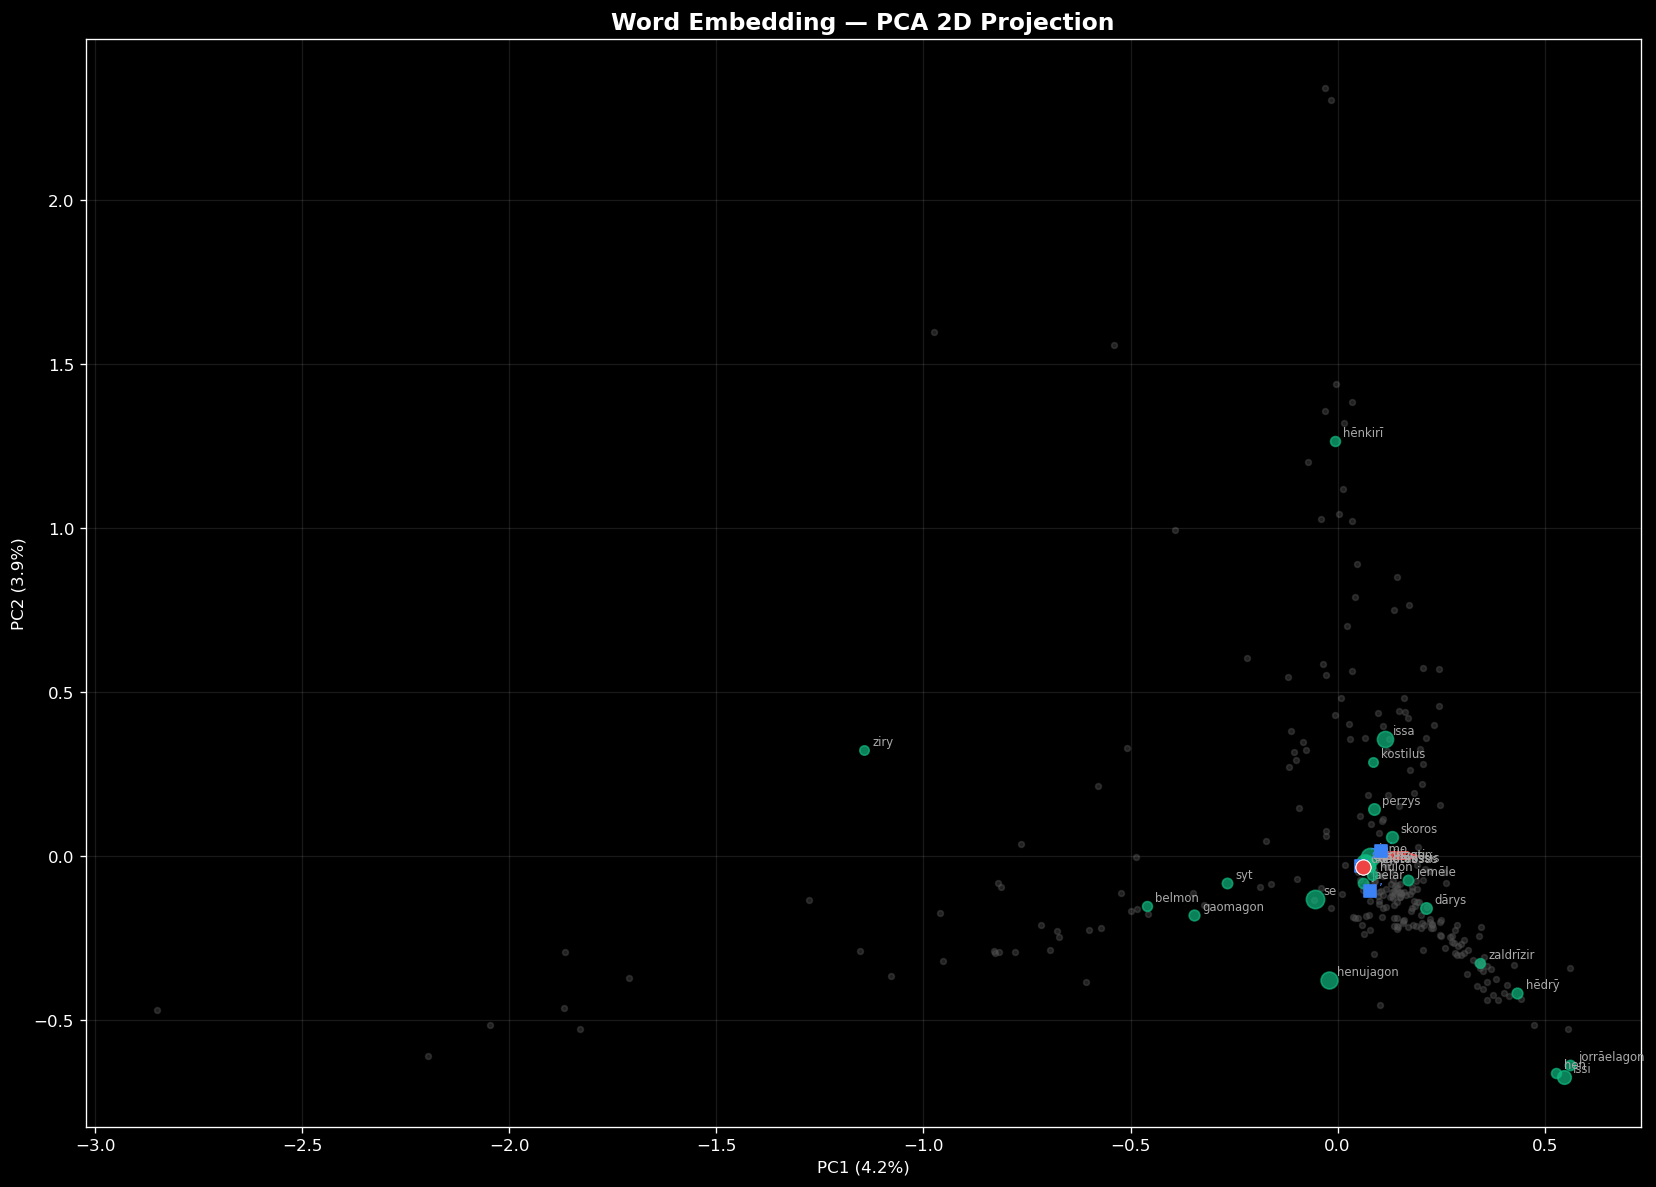

In [15]:
# PCA to 2D
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

# Categorize tokens
punct_set = {'.', ',', '?', '!', ';', ':'}
special_set = {'<PAD>', '<UNK>', '<BOS>', '<EOS>'}

fig, ax = plt.subplots(figsize=(14, 10))

for token, idx in vocab.items():
    x, y = emb_2d[idx]
    f = freq.get(token, 0)

    if token in special_set:
        ax.scatter(x, y, c='#ef4444', s=80, zorder=5, edgecolors='white', linewidth=0.5)
        ax.annotate(token, (x, y), fontsize=7, color='#ef4444', fontweight='bold',
                    xytext=(5, 5), textcoords='offset points')
    elif token in punct_set:
        ax.scatter(x, y, c='#3b82f6', s=60, zorder=4, marker='s')
        ax.annotate(token, (x, y), fontsize=8, color='#3b82f6',
                    xytext=(5, 5), textcoords='offset points')
    elif f >= 100:
        size = min(20 + f / 10, 120)
        ax.scatter(x, y, c='#10b981', s=size, alpha=0.7, zorder=3)
        ax.annotate(token, (x, y), fontsize=7, color='#aaa',
                    xytext=(5, 3), textcoords='offset points')
    else:
        ax.scatter(x, y, c='#555', s=12, alpha=0.4, zorder=1)

ax.set_title('Word Embedding — PCA 2D Projection', fontsize=14, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.grid(True, alpha=0.1)
plt.tight_layout()
plt.savefig('pca_embedding.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.4 Embedding Visualization (t-SNE 2D)

c:\Users\kenwi\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


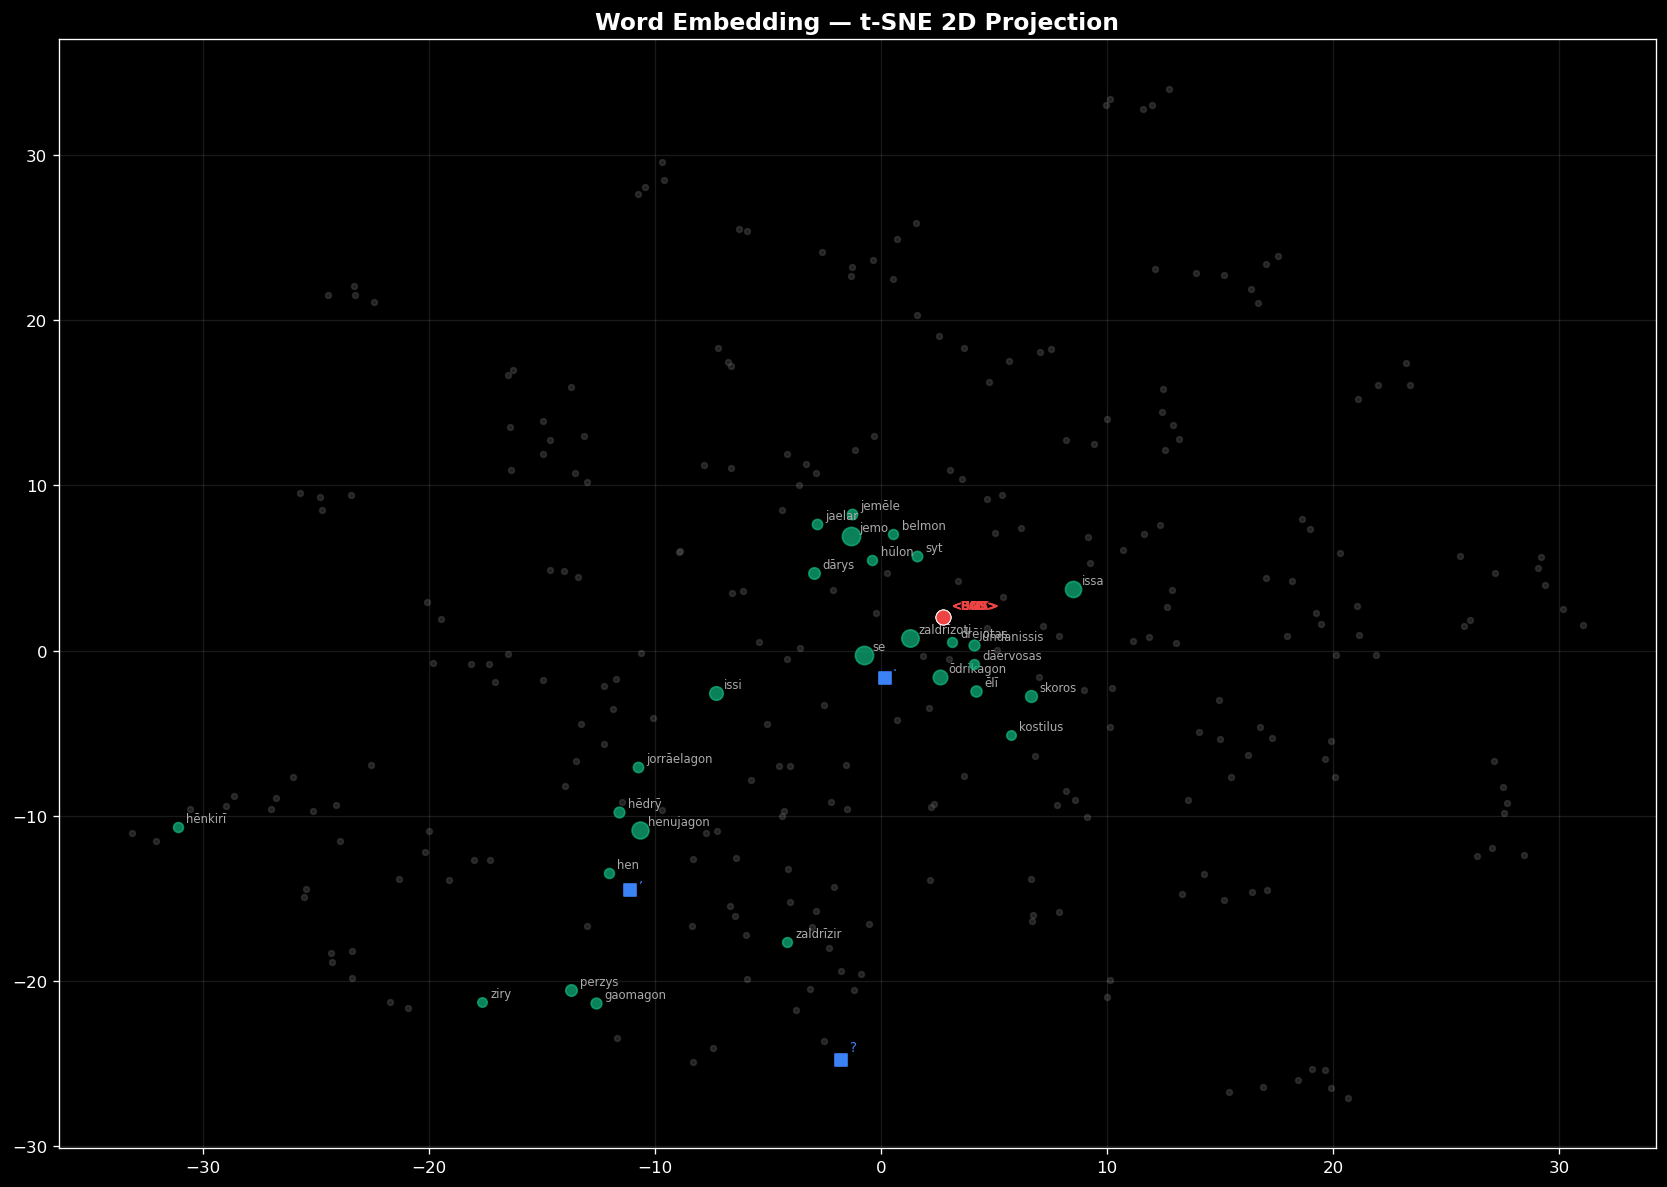

In [16]:
# t-SNE for better cluster separation
tsne = TSNE(n_components=2, perplexity=15, random_state=42, n_iter=1000)
emb_tsne = tsne.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(14, 10))

for token, idx in vocab.items():
    x, y = emb_tsne[idx]
    f = freq.get(token, 0)

    if token in special_set:
        ax.scatter(x, y, c='#ef4444', s=80, zorder=5, edgecolors='white', linewidth=0.5)
        ax.annotate(token, (x, y), fontsize=7, color='#ef4444', fontweight='bold',
                    xytext=(5, 5), textcoords='offset points')
    elif token in punct_set:
        ax.scatter(x, y, c='#3b82f6', s=60, zorder=4, marker='s')
        ax.annotate(token, (x, y), fontsize=8, color='#3b82f6',
                    xytext=(5, 5), textcoords='offset points')
    elif f >= 100:
        size = min(20 + f / 10, 120)
        ax.scatter(x, y, c='#10b981', s=size, alpha=0.7, zorder=3)
        ax.annotate(token, (x, y), fontsize=7, color='#aaa',
                    xytext=(5, 3), textcoords='offset points')
    else:
        ax.scatter(x, y, c='#555', s=12, alpha=0.4, zorder=1)

ax.set_title('Word Embedding — t-SNE 2D Projection', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.1)
plt.tight_layout()
plt.savefig('tsne_embedding.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Ringkasan & Statistik Pipeline

In [ ]:
print('=' * 55)
print('RINGKASAN PIPELINE')
print('=' * 55)
print()
print(f'📄 Corpus')
print(f'   Baris bersih:     {len(cleaned_lines)}')
print(f'   Total kata:       {len(cleaned.split())}')
print()
print(f'🔤 Tokenizer')
print(f'   Total tokens:     {len(all_tokens_flat)}')
print(f'   Unique tokens:    {len(set(all_tokens_flat))}')
print()
print(f'📖 Vocabulary')
print(f'   Vocab size:       {len(vocab)}')
print(f'   Special tokens:   {len(SPECIAL_TOKENS)}')
print(f'   Unique words:     {len(vocab) - len(SPECIAL_TOKENS)}')
print()
print(f'🧮 Embedding')
print(f'   Metode:           PPMI + SVD')
print(f'   Dimensi:          {EMBED_DIM}')
print(f'   Matrix shape:     {embeddings.shape}')
print(f'   Context window:   {WINDOW_SIZE}')
print(f'   File size:        {embeddings.nbytes / 1024:.1f} KB')
print()
print(f'📊 Co-occurrence')
print(f'   Non-zero cells:   {non_zero}')
print(f'   Sparsity:         {sparsity:.1%}')
print(f'   Variance (50 PC): {explained[49]:.1f}%')
print()
print('=' * 55)